<h2><font color="#004D7F" size=6>Módulo Extra. Preprocesamiento y Tratamiento de datos</font></h2>



<h1><font color="#004D7F" size=5>Desbalanceo de la Clase</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

<h2><font color="#004D7F" size=5>Índice</font></h2>
<a id="indice"></a>

* [1. Introducción](#section1)
    * [1.1. Librerías](#section11)
    * [1.2. Conjunto de datos](#section12)
* [2. Resultado de Linea Base](#section2)
    * [2.1. Procesamiento de datos](#section21)
    * [2.2. Evaluación del modelo](#section22)
    * [2.3. Resultados del modelo](#section23)
* [3. Evaluación de Modelos](#section3)
    * [3.1. Evaluación de Modelos probabilísticos](#section31)
    * [3.2. Evaluación de LoR equilibrada](#section32)
    * [3.3. Evaluación del muestreo de datos con modelos probabilísticos](#section33)
* [4. Fase de Forecasting](#section4)

In [1]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:98% }</style>"))

---
<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

Muchas tareas de clasificación desequilibradas requieren un modelo hábil que prediga una etiqueta de clase nítida, donde ambas clases son igualmente importantes. 

Una forma de evaluar los modelos de clasificación desequilibrados que predicen etiquetas nítidas es calcular la precisión separada en la clase positiva y la clase negativa, lo que se conoce como Sensibilidad y Especificidad. Luego, estas dos medidas se pueden promediar utilizando la media geométrica, denominada `media G`, que es insensible a la distribución de clases sesgada e informa correctamente sobre la habilidad del modelo en ambas clases.

<a id="section11"></a>
## <font color="#004D7F"> 1.1. Librerías</font>

Por último vamos a declarar algunas librerías generales que ya hemos estado trabajando y que usaremos a lo largo de la sección. 

**Nota**: Si es la primera vez que instala `imblear` debera reiniciar Jupyter Notebook.

In [18]:
!pip install imblearn

     |████████████████████████████████| 167 kB 246 kB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 542 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22
    Uninstalling scikit-learn-0.22:
      Successfully uninstalled scikit-learn-0.22


In [28]:
#importing libraries
import pandas as pd
import numpy as np
import collections as co
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Conjunto de datos</font>

En este proyecto, utilizaremos un conjunto de datos de aprendizaje automático desequilibrado estándar denominado conjunto de datos de "derrames de petróleo (oil spill)", conjunto de datos de "manchas de petróleo (oil slicks)" o simplemente "petróleo (oil)".

El conjunto de datos se desarrolló partiendo de imágenes satelitales del océano, algunas de las cuales contienen un derrame de petróleo y otras no. Las imágenes se dividieron en secciones y se procesaron utilizando algoritmos de visión por computadora para proporcionar un vector de características para describir el contenido de la sección o parche de la imagen.

A la tarea se le asigna un vector que describe el contenido de un patch de una imagen de satélite, luego predice si el patch contiene un derrame de petróleo o no, por ejemplo, debido al vertido ilegal o accidental de petróleo en el océano. Hay 937 casos. Cada caso está compuesto por 48 funciones numéricas derivadas de la visión por computadora, un número de parche y una etiqueta de clase.

Lo importante de este dataset es el desbalance que existe entre las clases: Hay 896 casos que no existe derrame de petróleo (clase 0) y 41 casos de derrame de petróleo (clase 1).

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
El artículo original se encuentra en la BBDD de [`Springer`](https://link.springer.com/article/10.1023/A:1007452223027).
</div>

Podemos ver que la primera columna contiene números enteros para el número patch. También podemos ver que las características derivadas de la visión por computadora tienen un valor real con diferentes escalas, como miles en la segunda columna y fracciones en otras columnas. Todas las variables de entrada son numéricas y no se tienen valores NaN.

In [19]:
filename = 'data/oil-spill.csv'
dataframe = pd.read_csv(filename, header=None)
dataframe

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,200,12,92.42,364.42,135,97200.0,59.42,10.34,884.0,0.17,...,381.84,254.56,84.85,146.97,4.50,0,2593.50,65.85,6.39,0
933,201,11,98.82,248.64,159,89100.0,59.64,10.18,831.0,0.17,...,284.60,180.00,150.00,51.96,1.90,0,4361.25,65.70,6.53,0
934,202,14,25.14,428.86,24,113400.0,60.14,17.94,847.0,0.30,...,402.49,180.00,180.00,0.00,2.24,0,2153.05,65.91,6.12,0
935,203,10,96.00,451.30,68,81000.0,59.90,15.01,831.0,0.25,...,402.49,180.00,90.00,73.48,4.47,0,2421.43,65.97,6.32,0


Echamos un vistazo a las características del dataset y verificamos el desbalance entre clases que se tiene.

In [4]:
print(dataframe.shape)

target = dataframe.values[:,-1]
dataframe.groupby(target).size()

(937, 50)


0.0    896
1.0     41
dtype: int64

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section2"></a>
# <font color="#004D7F"> 2. Resultado de Linea Base</font>

Para este ejercicio se evaluarán los modelos candidatos utilizando una validación cruzada estratificada con repetición de *k*-fold (`RepeatedStratifiedKFold`). Usaremos *k = 10*, lo que significa que cada pliegue contendrá aproximadamente 937/10 o aproximadamente 94 ejemplos.

La **validación cruzada estratificada** significa que cada *fold* contendrá la misma mezcla de ejemplos por clase, es decir, entre 96% y 4% de cada calase. **Repetir** significa que el proceso de evaluación se realizará varias veces para ayudar a evitar resultados fortuitos y capturar mejor la varianza del modelo elegido. Usaremos 3 repeticiones.

Recuerde que la sensibilidad es una medida de la precisión de la clase positiva y la especificidad es una medida de la precisión de la clase negativa.
* Sensibilidad = TruePositives / (TruePositives + FalseNegatives)
* Especificidad = TrueNegatives / (TrueNegatives + FalsePositives)

G-Mean, función [`geometric_mean_score()`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.metrics.geometric_mean_score.html) de Scikit-Learn, busca un equilibrio de estos puntajes, la media geométrica, donde un desempeño pobre para uno u otro da como resultado un puntaje promedio G bajo.
* G-Mean = sqrt (Sensibilidad * Especificidad)

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Procesamiento de datos</font>

Primero, podemos definir una función para cargar el conjunto de datos y dividir las columnas en variables de entrada y salida. También eliminaremos la columna 22 porque la columna contiene un solo valor y la primera columna que define el número patch de imagen. 

In [12]:
# Cargar el dataset
def load_dataset(data):
    # Eliminar Columnas
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # convertir a NumPy array
    data = data.values
    # Dividir input output
    X, y = data[:, :-1], data[:, -1]
    # Codificar el target en 0 o 1
    y = LabelEncoder().fit_transform(y)
    return X, y

<a id="section22"></a>
## <font color="#004D7F"> 2.2. Evaluación del modelo</font>

A continuación, se define una función que evaluará un modelo dado en el conjunto de datos y devolverá una lista de puntuaciones G-Mean para cada fold y repetición.

In [6]:
# evaluate a model
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Métrica de evaluación
    metric = make_scorer(geometric_mean_score)
    # Evaluación del modelo
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

<a id="section23"></a>
## <font color="#004D7F"> 2.3. Resultados del modelo</font>

Un modelo que predice la etiqueta de clase mayoritaria (0) o la etiqueta de clase minoritaria (1) para todos los casos dará como resultado una G-Mean de cero. Como tal, una buena estrategia predeterminada sería predecir al azar una etiqueta de clase u otra con una probabilidad del 50% y apuntar a una G-Mean de aproximadamente 0,5.

Esto se puede lograr usando la clase [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) y estableciendo el argumento `strategy` en `uniform`.

Una vez que se evalúa el modelo, podemos informar la media y la desviación estándar de las puntuaciones medias G directamente.

In [20]:
X, y = load_dataset(dataframe)
print(X.shape, y.shape, co.Counter(y))
# Definir el modelo
model = DummyClassifier(strategy='uniform')
# Evaluacion del modelo
scores = evaluate_model(X, y, model)
print('Mean G-Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(937, 47) (937,) Counter({0: 896, 1: 41})
Mean G-Mean: 0.516 (0.131)


En este caso, podemos ver que el algoritmo de la línea de base alcanza un G-Mean de 0.51, superando por poco el máximo teórico de 0,5. Esta puntuación proporciona un límite inferior en la habilidad del modelo; cualquier modelo que alcance un promedio G-Mean por encima de aproximadamente 0,51 tiene habilidad, mientras que los modelos que logran una puntuación por debajo de este valor no tienen habilidad.

Es interesante notar que un buen G-MEan reportado en el documento fue de aproximadamente 0,811, aunque el procedimiento de evaluación del modelo fue diferente. Esto proporciona un objetivo aproximado para un "buen" rendimiento en este conjunto de datos.

Ahora que tenemos un arnés de prueba y una línea de base en el rendimiento, podemos comenzar a evaluar algunos modelos en este conjunto de datos.

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section3"></a>
# <font color="#004D7F"> 3. Evaluación de Modelos</font>

En esta sección, evaluaremos un conjunto de diferentes técnicas en el conjunto de datos utilizando el arnés de prueba desarrollado en la sección anterior.

El objetivo es tanto demostrar cómo resolver el problema de manera sistemática como demostrar la capacidad de algunas técnicas diseñadas para problemas de clasificación desequilibrada.

<a id="section31"></a>
## <font color="#004D7F"> 3.1. Evaluación de Modelos probabilísticos</font>

Los modelos probabilísticos son aquellos que se ajustan a los datos en un marco probabilístico y, en general, funcionan bien en conjuntos de datos de clasificación desequilibrados. Evaluaremos los siguientes modelos probabilísticos con hiperparámetros predeterminados en el conjunto de datos:

* Logistic Regression (LoR)
* Linear Discriminant Analysis (LDA)
* Gaussian Naive Bayes (NB)

Tanto LR como LDA son sensibles a la escala de las variables de entrada y, a menudo, esperan y/o funcionan mejor si las variables de entrada con diferentes escalas se normalizan o estandarizan como un paso previo al procesamiento.


>LR 0.672 (0.203)
>LDA 0.755 (0.147)
>NB 0.707 (0.202)


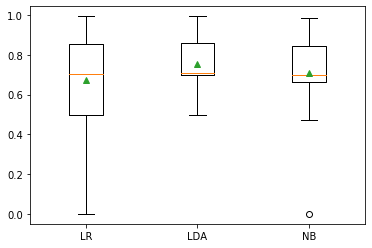

In [23]:
models, names, results = list(), list(), list()
# LoR
models.append(Pipeline(steps=[('t', StandardScaler()),('m',LogisticRegression(solver='liblinear'))]))
names.append('LR')
# LDA
models.append(Pipeline(steps=[('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]))
names.append('LDA')
# NB
models.append(GaussianNB())
names.append('NB')

# Evaluar cada modelo
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

En este caso, podemos ver que cada algoritmo tiene habilidad, logrando una media G-Mean superior a 0,5. Los resultados sugieren que un LDA podría ser el mejor rendimiento de los modelos probados.

En la Figura podemos ver que la distribución tanto para LDA como para NB es compacta y hábil y que el LoR puede tener algunos resultados durante la ejecución en los que el método funcionó mal, empujando la distribución hacia abajo.

Esto resalta que no es solo el desempeño medio, sino también la consistencia del modelo lo que debe tenerse en cuenta al seleccionar un modelo.

<a id="section32"></a>
## <font color="#004D7F"> 3.2. Evaluación de LoR equilibrada</font>

El algoritmo de LoR admite una modificación que ajusta la importancia de los errores de clasificación para que sean inversamente proporcionales a la ponderación de la clase. Esto permite que el modelo aprenda mejor el límite de la clase a favor de la clase minoritaria, lo que podría ayudar al rendimiento G-MEan general. Podemos lograr esto estableciendo el argumento `class_weight = 'balanced'`.

Además, LoR es sensible a la escala de las variables de entrada y puede funcionar mejor con entradas normalizadas o estandarizadas; como tal, es una buena idea probar ambos para un conjunto de datos determinado. Además, se puede usar una distribución de potencia para extender la distribución de cada variable de entrada y hacer que las variables con una distribución similar a la de Gauss sean más gaussianas. Esto puede beneficiar a modelos como LoR que hacen suposiciones sobre la distribución de variables de entrada.

>Balanced 0.848 (0.115)
>Balanced-Norm 0.836 (0.088)
>Balanced-Std 0.834 (0.129)
>Balanced-Power 0.862 (0.124)


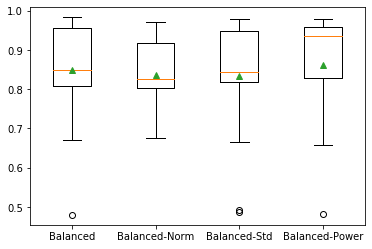

In [27]:
models, names, results = list(), list(), list()
# LoR Balanced
models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
names.append('Balanced')
# LoR Balanced + Normalization
models.append(Pipeline(steps=[('t', MinMaxScaler()),('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]))
names.append('Balanced-Norm')
# LoR Balanced + Standardization
models.append(Pipeline(steps=[('t', StandardScaler()),('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]))
names.append('Balanced-Std')
# LoR Balanced  + Transform
models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]))
names.append('Balanced-Power')

# Evaluar cada model
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

En este caso, podemos ver que la versión balanceada de regresión logística funciona mucho mejor que todos los modelos probabilísticos evaluados en la sección anterior.

Los resultados sugieren que quizás el uso de LoR equilibrado con normalización de datos para el preprocesamiento rinde mejor en este conjunto de datos con una puntuación G-Mean media de aproximadamente 0,848 y con transformación 0,862, llegando, como muestra la Figura, a casi 1. Esto está en el rango o mejor que los resultados reportados en el artículo.

<a id="section33"></a>
## <font color="#004D7F"> 3.3. Evaluación el muestreo de datos con modelos probabilísticos</font>

El muestreo de datos proporciona una forma de preparar mejor el conjunto de datos de entrenamiento desequilibrado antes de ajustar un modelo.

Quizás el muestreo de datos más popular es la técnica de sobremuestreo [`SMOTE`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) para crear nuevos ejemplos sintéticos para la clase minoritaria. Esto se puede combinar con el algoritmo del [Vecino Más Cercano Editado (ENN)](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.EditedNearestNeighbours.html) que ubicará y eliminará ejemplos del conjunto de datos que sean ambiguos, lo que facilitará que los modelos aprendan a discriminar entre las dos clases. Esta combinación se llama SMOTE-ENN y se puede implementar usando la clase [`SMOTEENN`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTEENN.html) de la librería imabalanced-learn.

SMOTE y ENN funcionan mejor cuando los datos de entrada se escalan de antemano. Esto se debe a que ambas técnicas implican el uso interno del algoritmo de vecino más cercano y este algoritmo es sensible a las variables de entrada con diferentes escalas. Compararemos cuatro variaciones del modelo de regresión logística con muestreo de datos, específicamente:
* SMOTEENN + LR
* Normalización + SMOTEENN + LR
* Estandarización + SMOTEENN + LR
* Normalización + Transormación + SMOTEENN + LR

>LR 0.865 (0.093)
>Norm 0.825 (0.114)
>Std 0.817 (0.147)
>Power 0.883 (0.121)


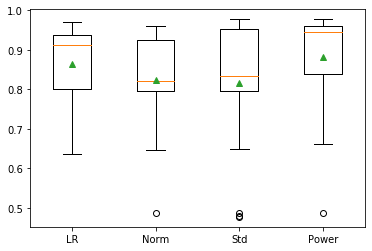

In [30]:
models, names, results = list(), list(), list()
# SMOTEENN
models.append(Pipeline(steps=[('e', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))), ('m', LogisticRegression(solver='liblinear'))]))
names.append('LR')
# SMOTEENN + Norm
models.append(Pipeline(steps=[('t', MinMaxScaler()), ('e', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))), ('m', LogisticRegression(solver='liblinear'))]))
names.append('Norm')
# SMOTEENN + Std
models.append(Pipeline(steps=[('t', StandardScaler()), ('e', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))), ('m', LogisticRegression(solver='liblinear'))]))
names.append('Std')
# SMOTEENN + Power
models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))), ('m', LogisticRegression(solver='liblinear'))]))
names.append('Power')
# evaluate each model
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    results.append(scores)

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

En este caso, podemos ver que la adición de SMOTEENN mejora el rendimiento del algoritmo LoR predeterminado, logrando una media G-Mean de 0,865. Esto es incluso mejor que el LoR equilibrado sin ningún escalado de datos (sección anterior) que logró una G-Mean de aproximadamente 0,878.

Los resultados sugieren que quizás la combinación final de normalización, transformación de potencia y estandarización logre una puntuación ligeramente mejor que la LoR predeterminada con SMOTEENN con una G-Mean de aproximadamente 0,873.

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section4"></a>
# <font color="#004D7F"> 4. Fase de Forecasting</font>

El uso de SMOTEENN con Regresión logística directamente sin ningún escalado de datos probablemente proporciona el modelo más simple y de mejor rendimiento que podría usarse en el futuro.

Primero, podemos definir el modelo como una tubería. Una vez definido, podemos ajustarlo a todo el conjunto de datos de entrenamiento. Una vez que se ajusta, podemos usarlo para hacer predicciones de nuevos datos llamando a la función `predict()`. Esto devolverá la etiqueta de clase de 0 para ningún derrame de petróleo o 1 para un derrame de petróleo.

In [37]:
# Los nuevos datos tienen todas las características
def load_dataset(filename):
    data = pd.read_csv(filename, header=None)
    data = data.values
    X, y = data[:, 1:-1], data[:, -1]
    y = LabelEncoder().fit_transform(y)
    return X, y

X, y = load_dataset(filename)

# Definición del modelo
smoteenn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('e', smoteenn), ('m', model)])
# Ajuste del modelo
pipeline.fit(X, y)

# Evaluación con la clase 0
print('Non-Spill Cases:')
data = [[329,1627.54,1409.43,51,822500,35,6.1,4610,0.17,178.4,0.2,0.24,0.39,0.12,0.27,138.32,34.81,2.02,0.14,0.19,75.26,0,0.47,351.67,0.18,9.24,0.38,2.57,-2.96,-0.28,1.93,0,1.93,34,1710,0,25.84,78,55,1460.31,710.63,451.78,150.85,3.23,0,4530.75,66.25,7.85],
        [3234,1091.56,1357.96,32,8085000,40.08,8.98,25450,0.22,317.7,0.18,0.2,0.49,0.09,0.41,114.69,41.87,2.31,0.15,0.18,75.26,0,0.53,351.67,0.18,9.24,0.24,3.56,-3.09,-0.31,2.17,0,2.17,281,14490,0,80.11,78,55,4287.77,3095.56,1937.42,773.69,2.21,0,4927.51,66.15,7.24],
        [2339,1537.68,1633.02,45,5847500,38.13,9.29,22110,0.24,264.5,0.21,0.26,0.79,0.08,0.71,89.49,32.23,2.2,0.17,0.22,75.26,0,0.51,351.67,0.18,9.24,0.27,4.21,-2.84,-0.29,2.16,0,2.16,228,12150,0,83.6,78,55,3959.8,2404.16,1530.38,659.67,2.59,0,4732.04,66.34,7.67]]

#Hacer predicciones
for row in data:
    yhat = pipeline.predict([row])
    label = yhat[0]
    print('>Predecido=%d (esperado 0)' % (label))

# Evaluación con la clase 1
print('Spill Cases:')
data = [[2971,1020.91,630.8,59,7427500,32.76,10.48,17380,0.32,427.4,0.22,0.29,0.5,0.08,0.42,149.87,50.99,1.89,0.14,0.18,75.26,0,0.44,351.67,0.18,9.24,2.5,10.63,-3.07,-0.28,2.18,0,2.18,164,8730,0,40.67,78,55,5650.88,1749.29,1245.07,348.7,4.54,0,25579.34,65.78,7.41],
    [3155,1118.08,469.39,11,7887500,30.41,7.99,15880,0.26,496.7,0.2,0.26,0.69,0.11,0.58,118.11,43.96,1.76,0.15,0.18,75.26,0,0.4,351.67,0.18,9.24,0.78,8.68,-3.19,-0.33,2.19,0,2.19,150,8100,0,31.97,78,55,3471.31,3059.41,2043.9,477.23,1.7,0,28172.07,65.72,7.58],
    [115,1449.85,608.43,88,287500,40.42,7.34,3340,0.18,86.1,0.21,0.32,0.5,0.17,0.34,71.2,16.73,1.82,0.19,0.29,87.65,0,0.46,132.78,-0.01,3.78,0.7,4.79,-3.36,-0.23,1.95,0,1.95,29,1530,0.01,38.8,89,69,1400,250,150,45.13,9.33,1,31692.84,65.81,7.84]]

#Hacer las predicciones
for row in data:
    yhat = pipeline.predict([row])
    label = yhat[0]
    print('>Predecido=%d (esperado 1)' % (label))

Non-Spill Cases:
>Predecido=0 (esperado 0)
>Predecido=0 (esperado 0)
>Predecido=0 (esperado 0)
Spill Cases:
>Predecido=1 (esperado 1)
>Predecido=1 (esperado 1)
>Predecido=1 (esperado 1)


Al ejecutar el ejemplo, primero se ajusta el modelo a todo el conjunto de datos de entrenamiento.

Luego, el modelo de ajuste utilizado para predecir la etiqueta de un derrame de petróleo para los casos en los que sabemos que no hay ninguno, elegido del archivo del conjunto de datos. Podemos ver que todos los casos están correctamente predichos.

Luego, algunos casos de derrames de petróleo reales se utilizan como entrada para el modelo y se predice la etiqueta. Como podríamos haber esperado, se vuelven a predecir las etiquetas correctas.

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>